# MaskRCNN for Chest X-ray abnormalities detection

In [1]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imgaug import augmenters as iaa

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "/home/daitran/Desktop/research/kaggle/VinBigData/train/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/'

In [3]:
orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

In [4]:
samples_df = pd.read_csv('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/1024_encoded_maskrcnn.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})

In [5]:
samples_df.head()

,image_id,CategoryId,EncodedPixels,Height,Width
0,9a5094b2563a1ef3ff50dc5c7ff71345,"[3, 10, 11, 3, 3, 0]",[348764 199 349788 199 350812 199 351836 199 3...,1024,1024
1,051132a778e61a86eb147c7c6f564dfe,"[0, 0, 3, 3, 11, 0, 3]",[575753 98 576777 98 577801 98 578825 98 57984...,1024,1024
2,1c32170b4af4ce1a3030eb8167753b06,"[11, 13, 11, 13, 13, 13, 11, 13, 13]",[259192 25 260216 25 261240 25 262264 25 26328...,1024,1024
3,0c7a38f293d5f5e4846aa4ca6db4daf1,"[5, 5, 8, 5, 9]",[618595 771 619619 771 620643 771 621667 771 6...,1024,1024
4,47ed17dcb2cbeec15182ed335a8b5a9e,"[8, 9, 8, 9, 9, 8, 7, 7]",[228047 40 229071 40 230095 40 231119 40 23214...,1024,1024


### Implement MaskRCNN

In [6]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
NUM_CATS = 14
IMAGE_SIZE = 1024

In [8]:
# Create Config 
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 10 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7


    STEPS_PER_EPOCH = int(len(samples_df)*0.8/IMAGES_PER_GPU)
    VALIDATION_STEPS = int(len(samples_df)/IMAGES_PER_GPU)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()

In [9]:
category_list = ["Aortic enlargement", "Atelectasis","Calcification","Cardiomegaly","Consolidation","ILD",
                "Infiltration", "Lung opacity", "Nodule/ Mass","Other lesion","Pleural effusion",
                "Pleural thickening", "Pneumothorax","Pulmonary fibrosis"]
# category_list

In [10]:
# Create Mask RCNN formart dataset
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".png",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'],
                           img_org_id = row.image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

## [Stratified k-fold](https://www.kaggle.com/backtracking/smart-data-split-train-eval-for-object-detection)

In [11]:
df = orin_df
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
df_folds = df[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = df.groupby('image_id')['class_id'].nunique()

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

# example with fold 0
df_folds.reset_index(inplace=True)

df_valid = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')

df_train = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')


In [12]:
print(len(df_train))
print(len(df_valid))

28940
7156


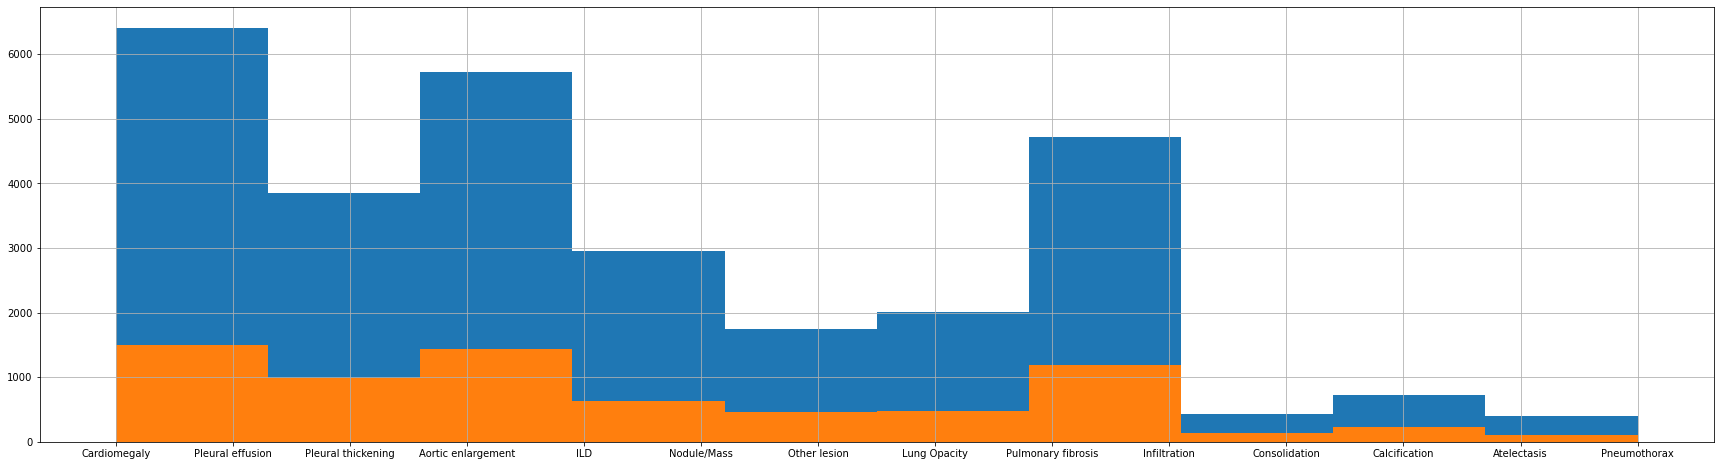

In [14]:
plt.figure(figsize=(30, 8))
df_train['class_name'].hist()
df_valid['class_name'].hist()
plt.savefig('k-fold.jpg')
plt.show()

### Filter with encoded csv

In [14]:
maskrcnn_df_train = samples_df[~samples_df['image_id'].isin(df_valid['image_id'])]
maskrcnn_df_train

,image_id,CategoryId,EncodedPixels,Height,Width
0,9a5094b2563a1ef3ff50dc5c7ff71345,"[3, 10, 11, 3, 3, 0]",[348764 199 349788 199 350812 199 351836 199 3...,1024,1024
1,051132a778e61a86eb147c7c6f564dfe,"[0, 0, 3, 3, 11, 0, 3]",[575753 98 576777 98 577801 98 578825 98 57984...,1024,1024
3,0c7a38f293d5f5e4846aa4ca6db4daf1,"[5, 5, 8, 5, 9]",[618595 771 619619 771 620643 771 621667 771 6...,1024,1024
4,47ed17dcb2cbeec15182ed335a8b5a9e,"[8, 9, 8, 9, 9, 8, 7, 7]",[228047 40 229071 40 230095 40 231119 40 23214...,1024,1024
5,d3637a1935a905b3c326af31389cb846,"[0, 13, 11, 8, 13, 13, 11, 13, 8, 8, 13]",[605449 76 606473 76 607497 76 608521 76 60954...,1024,1024
...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,"[0, 10, 13, 6, 4, 13, 10, 10]",[512275 138 513299 138 514323 138 515347 138 5...,1024,1024
36092,26d1d5a0ef2e692c6340e74859ffdc53,"[8, 10, 10, 13, 9, 11, 13, 9, 13, 11, 0, 8, 13...",[469130 24 470154 24 471178 24 472202 24 47322...,1024,1024
36093,22672ab82c290c20b86863291e25ef6c,"[5, 11, 10, 9, 10, 9, 11, 5, 13, 13, 11, 13, 1...",[153799 421 154823 421 155847 421 156871 421 1...,1024,1024
36094,db169d0be36123bd55b866d6aa73983b,"[10, 9, 9, 9, 0, 11, 7, 0, 9, 9, 13, 9, 9, 9, 9]",[21097 98 22121 98 23145 98 24169 98 25193 98 ...,1024,1024


In [15]:
maskrcnn_df_val = samples_df[~samples_df['image_id'].isin(df_train['image_id'])]
maskrcnn_df_val

,image_id,CategoryId,EncodedPixels,Height,Width
2,1c32170b4af4ce1a3030eb8167753b06,"[11, 13, 11, 13, 13, 13, 11, 13, 13]",[259192 25 260216 25 261240 25 262264 25 26328...,1024,1024
12,fb8e11c6b2886b2d41b379e0598669b9,"[0, 10, 7, 4, 11, 8, 7, 11, 11, 8, 0, 8, 13, 1...",[633145 101 634169 101 635193 101 636217 101 6...,1024,1024
13,0622cd29e4e0e4f198abf15614819ae8,"[3, 0, 0, 0, 3, 3]",[441950 150 442974 150 443998 150 445022 150 4...,1024,1024
15,22b8e616a61bbc4caaed0cf23b7159df,"[13, 13, 13, 0, 11, 0]",[237826 99 238850 99 239874 99 240898 99 24192...,1024,1024
18,d7aea6f37597df566725da73655edcc2,"[6, 11, 11, 6, 3, 10, 0, 6, 0, 7, 11, 6, 10, 4...",[715096 266 716120 266 717144 266 718168 266 7...,1024,1024
...,...,...,...,...,...
36062,b6bb5088976d0d3d51f3041b2172cffb,"[13, 11, 0, 11, 11, 0, 0, 13, 11, 6, 13]",[259299 134 260323 134 261347 134 262371 134 2...,1024,1024
36077,cc47c14b9aa97e08fad1925a6dc1efee,"[11, 13, 13, 2, 11, 13]",[602313 33 603337 33 604361 33 605385 33 60640...,1024,1024
36078,b11960f23db725bb4ba6f6741586a5f7,"[13, 0, 3, 9, 0, 3, 12, 0, 11]",[242954 84 243978 84 245002 84 246026 84 24705...,1024,1024
36080,5bc0153d83e1514ca428123b264a3aa8,"[7, 13, 11, 11, 13, 13, 11]",[265406 85 266430 85 267454 85 268478 85 26950...,1024,1024


### Convert to MaskRCNN form

In [16]:
train_dataset = DiagnosticDataset(maskrcnn_df_train)
train_dataset.prepare()

valid_dataset = DiagnosticDataset(maskrcnn_df_val)
valid_dataset.prepare()

In [17]:
# Show validation dataset information
print("Images: {}\nClasses: {}".format(len(train_dataset.image_ids), train_dataset.class_names))

Images: 28940
Classes: ['BG', 'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung opacity', 'Nodule/ Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']


In [18]:
# Show validation dataset information
print("Images: {}\nClasses: {}".format(len(valid_dataset.image_ids), valid_dataset.class_names))

Images: 7156
Classes: ['BG', 'Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung opacity', 'Nodule/ Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']


## Augmentation

In [19]:
# AUGMENTATION IMPLEMENTATION
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/ccff375f4139cef65b98385224cfc810.png


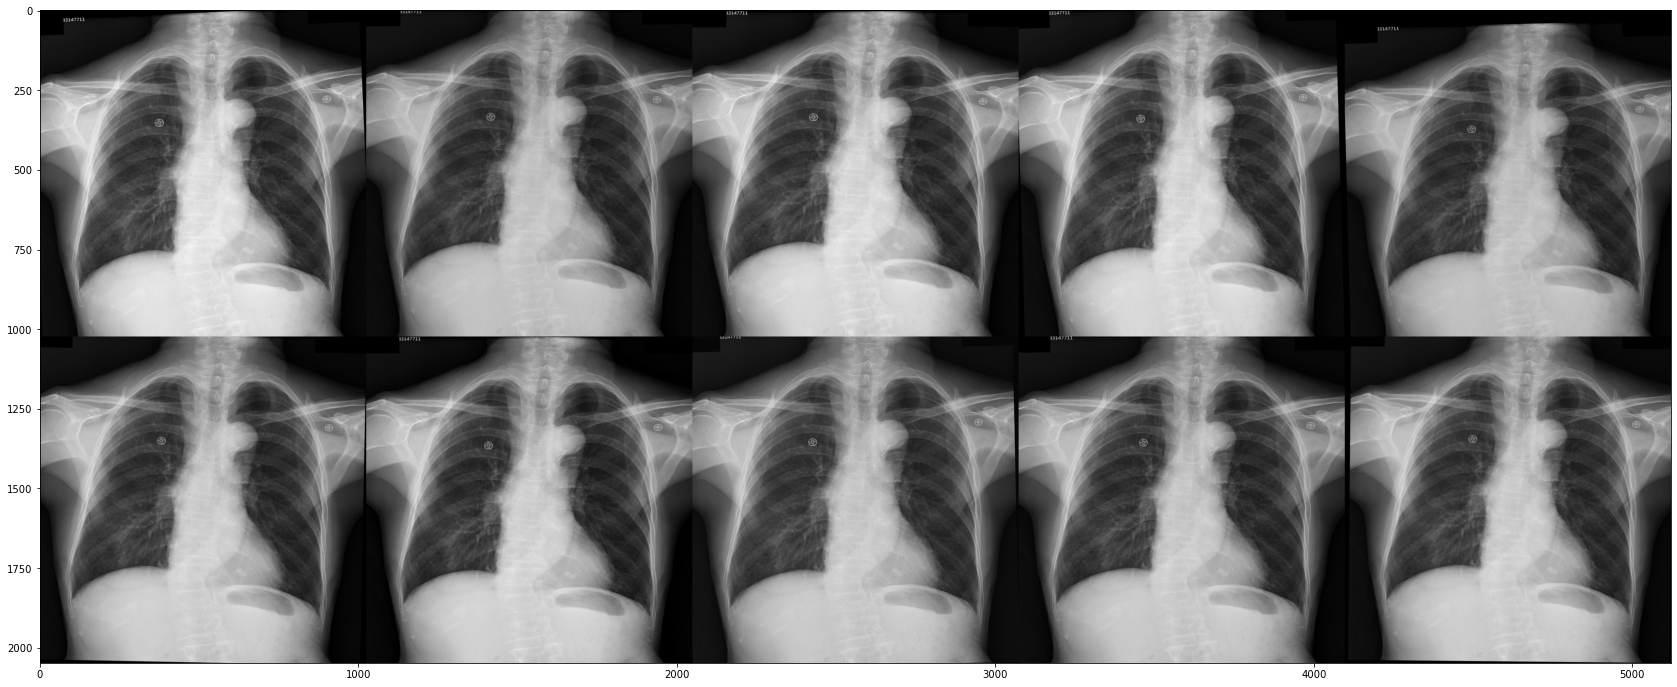

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/0d30dc1e0070e7a934f39452e3ad3b83.png


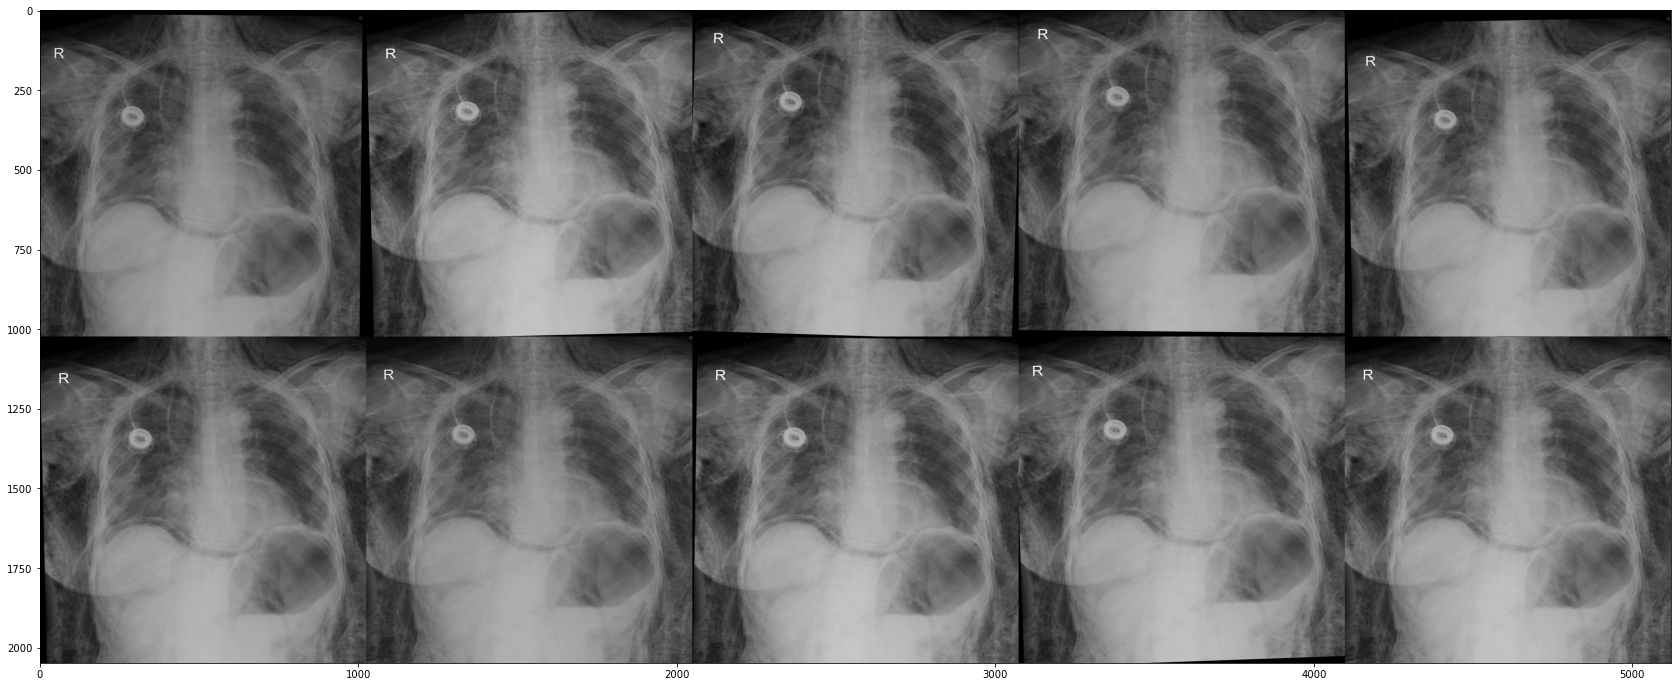

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/86ea362edec93fb69697ad8e6920d0d7.png


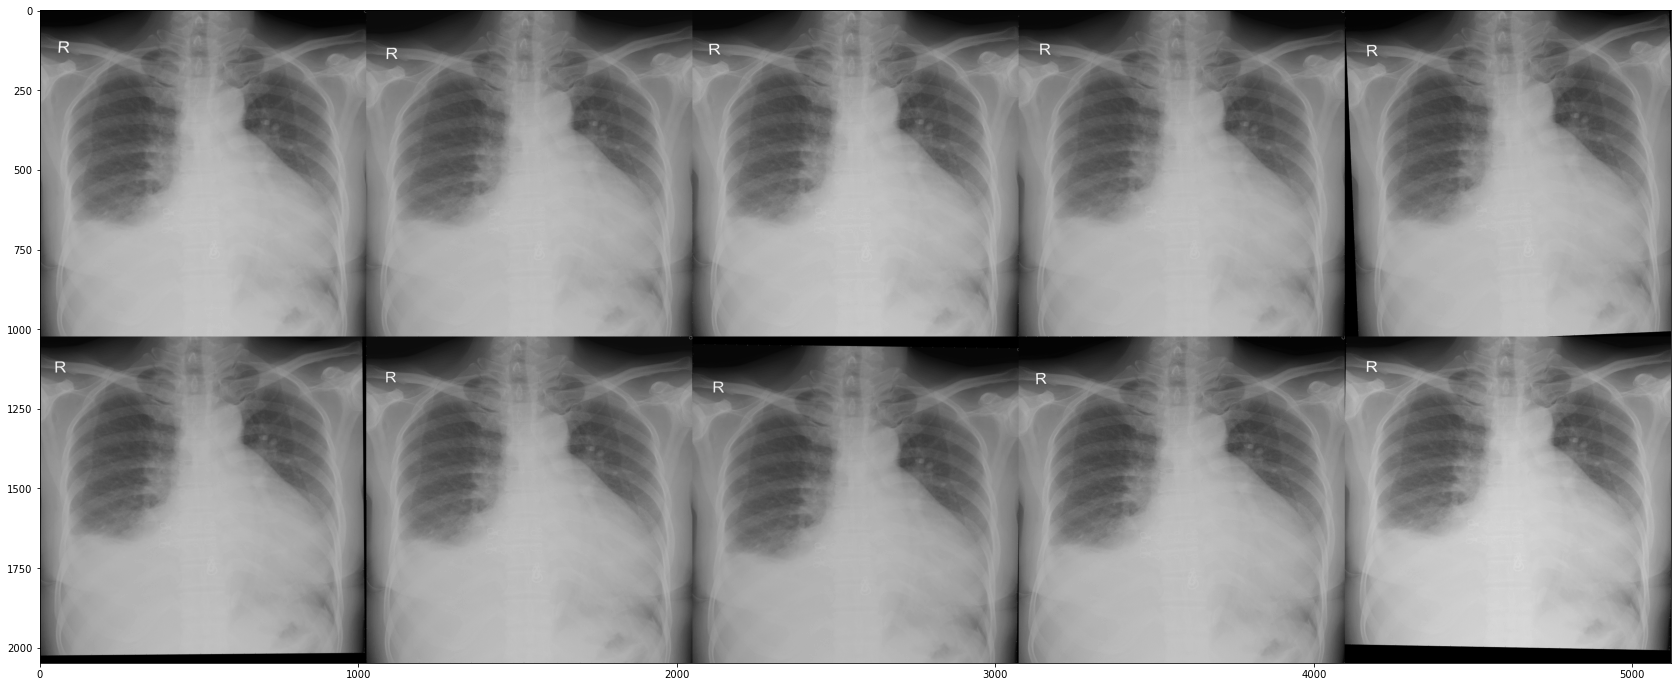

In [20]:
for _ in range(3):
    image_jpg_id = random.choice(valid_dataset.image_ids)
    print(valid_dataset.image_info[image_jpg_id]['path'])

    image = valid_dataset.load_image(image_jpg_id)

    # test on the same image as above
    imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
    plt.figure(figsize=(30, 12))
    plt.imshow(imggrid[:, :, 0], cmap='gray')
    plt.show()

In [22]:
# Load weight
# WEIGHT_PATH = '/home/dairesearch/home/dairesearch/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/weights/mask_rcnn_coco.h5'

WEIGHT_PATH = '/media/daitran/2E3240D23240A0A7/Users/windows/Desktop/Research/3. Code/0_github_code/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/weights/mask_rcnn_coco.h5'
# Create model and load pretrained weights

In [23]:

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")

model.load_weights(WEIGHT_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
LR = 1e-4
EPOCHS = 1

In [1]:
history = model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS,
            layers='all',
            augmentation=augmentation)

# Plot history train/ val
history = model.keras_model.history.history